In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint_adjoint
from torchdiffeq import odeint

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
grid_size = 32

Action in 2D:

$$
S_L(\phi) = \sum_x \bigg( -2\kappa \sum_{\mu=1}^2 \phi(x)\phi(x+\hat{\mu}) + (1-2\lambda)\phi^2(x) + \lambda \phi^4(x) \bigg)
$$

In [4]:
lam = 0.02

In [5]:
def action(phi, kappa):
    # potential term
    pot = torch.sum((1. - 2. * lam) * phi**2 + lam * phi**4, dim=(1,2))
    # kinetic term
    kin = 0
    for mu in range(1,3):
        kin += phi * torch.roll(phi, -1, dims=mu)
    kin = torch.sum(kin, dim=(1,2))
    action = pot - 2. * kappa * kin
    return action

In [6]:
# Generate initial configuration - Dims as follows: batch -- x_dim -- y_dim
def generate_initial_configs(n):
    return torch.randn(n, grid_size, grid_size, device=device)

Hybrid Monte Carlo

$$
Z = \int \prod_x \mathrm{d} \pi_x \prod_x \mathrm{d} \phi_x e^{- H(\pi,\phi)}
$$

$$
H(\pi,\phi) = \frac{1}{2} \sum_x \pi_x^2 + S(\phi)
$$

In [7]:
def hamiltonian(pi, phi, kappa):
    return torch.sum(pi**2, dim=(1,2)) / 2. + action(phi, kappa)

HMC step 1:

Choose new random momenta $\pi$

$$
P(\pi_i)\propto \exp(-\pi_i^2/2)
$$

In [8]:
def rand_momenta(n):
    return torch.randn(n, grid_size, grid_size, device=device)

HMC step 2:

Solve Hamilton eqs

$$
\frac{\mathrm{d}}{\mathrm{d}\tau} \phi_x(\tau) = \frac{\partial}{\partial \pi_x} H(\pi(\tau),\phi(\tau))
= \pi_x
$$

$$
\frac{\mathrm{d}}{\mathrm{d}\tau} \pi_x(\tau) = -\frac{\partial}{\partial \phi_x} H(\pi(\tau),\phi(\tau))
= -\frac{\partial}{\partial \phi_x} S(\phi(\tau))
$$

In [9]:
def action_grad(phi, kappa):
    kin_term = - 2. * kappa * (torch.roll(phi, -1, dims=1) + torch.roll(phi, 1, dims=1)
                               + torch.roll(phi, -1, dims=2) + torch.roll(phi, 1, dims=2))
    pot_term = 2. * (1. - 2. * lam) * phi + 4. * lam * phi**3
    drift = kin_term + pot_term
    return drift

In [10]:
def hamilton_dynamics(pi, phi, tau, epsilon, kappa):
    # Using the leap frog method
    n_steps = tau // epsilon
    phi = phi + epsilon / 2. * pi
    for i in range(int(n_steps)-1):
        pi = pi - epsilon * action_grad(phi, kappa)
        phi = phi + epsilon * pi
    pi = pi - epsilon * action_grad(phi, kappa)
    phi = phi + epsilon / 2. * pi
        
    return pi, phi

HMC step 3:

Acceptance step

$$
P_{accept} = \min(1, \exp(-\Delta H)) ,\: \Delta H = H(\pi',\phi') - H(\pi,\phi)
$$

In [11]:
def metropolis_step(pi_old, phi_old, pi_new, phi_new, kappa):
    delta_h = hamiltonian(pi_new, phi_new, kappa) - hamiltonian(pi_old, phi_old, kappa)
    p_accept = torch.exp(-delta_h)
    #print(p_accept)
    phi = torch.zeros_like(phi_old)
    update_check = torch.ge(p_accept, torch.rand((phi_old.shape[0]), device=device))
    phi[update_check] = phi_new[update_check]
    phi[~update_check] = phi_old[~update_check]
    return phi

The whole thing:

In [12]:
def hmc_alg(n, hmc_steps, kappa, tau, epsilon=1e-4):
    phi = generate_initial_configs(n)
    pi = rand_momenta(n)
    tqdm_epoch = tqdm_notebook(range(hmc_steps))
    for i in tqdm_epoch:
        pi_new, phi_new = hamilton_dynamics(pi, phi, tau, epsilon, kappa)
        phi = metropolis_step(pi, phi, pi_new, phi_new, kappa)
        pi = rand_momenta(n)
    return phi

### Observables

In [13]:
#plot configs
def plot_samples(samples, img_per_row = 2):
    # Input: - Torch tensor of shape sample-number x channels x dim x dim
    #        - number of samples per row
    samples = samples.cpu().numpy()
    fig, ax = plt.subplots(img_per_row, img_per_row, figsize=(10,10))
    for i in range(img_per_row):
        for j in range(img_per_row):
            ind = i*img_per_row + j
            ax[i,j].imshow(samples[ind], vmin=-4, vmax=4, cmap='viridis')
            ax[i,j].axes.xaxis.set_visible(False)
            ax[i,j].axes.yaxis.set_visible(False)
    plt.show()

In [14]:
def magnetization(samples):
    grid_size = samples.shape[-1]
    m = torch.sum(samples, dim=(1,2)) / grid_size**2
    return m

In [15]:
def magnetization_mean(samples):
    grid_size = samples.shape[-1]
    m = torch.sum(samples, dim=(1,2)) / grid_size**2
    return torch.mean(m)

In [16]:
def susceptibility(samples):
    grid_size = samples.shape[-1]
    m = magnetization(samples)
    return grid_size**2 * (torch.mean(m**2) - torch.mean(torch.abs(m))**2)

In [17]:
def binder_cumulant(samples):
    m = magnetization(samples)
    return 1. - 1./3. * torch.mean(m**4) / torch.mean(m**2)**2

In [18]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = torch.zeros([n])
    for i in range(n):
        dataset = torch.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = torch.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = torch.sqrt(variance)
    return expectation_value, std_dev

### Broken phase

In [20]:
training_samples = hmc_alg(n=10000, hmc_steps=10000, kappa=0.3, tau=1e1, epsilon=3e-2).cpu()

  0%|          | 0/10000 [00:00<?, ?it/s]

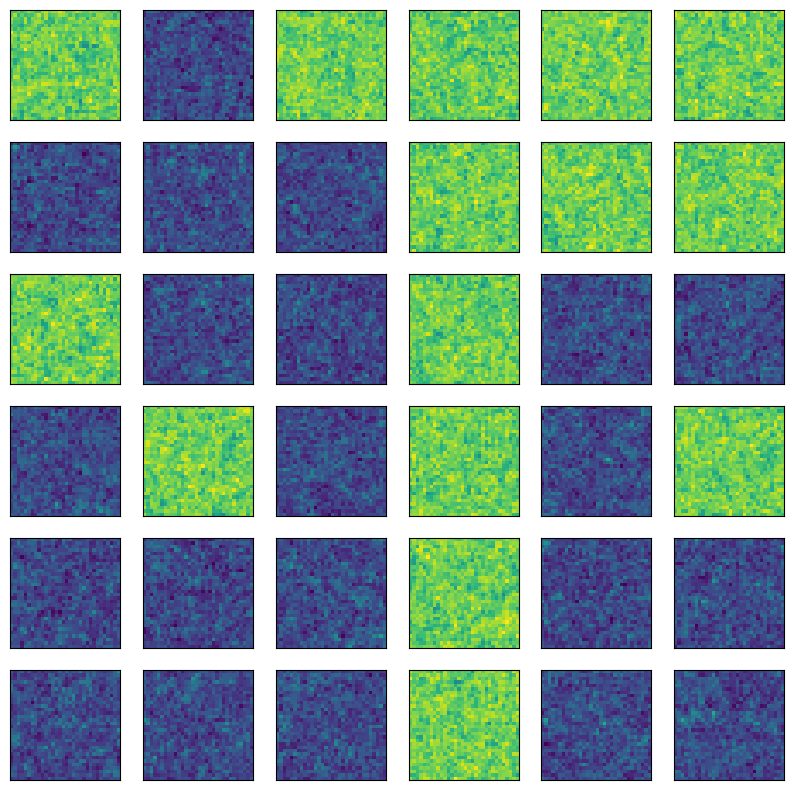

In [21]:
index = torch.randperm(training_samples.shape[0])
plot_samples(training_samples[index], img_per_row=6)

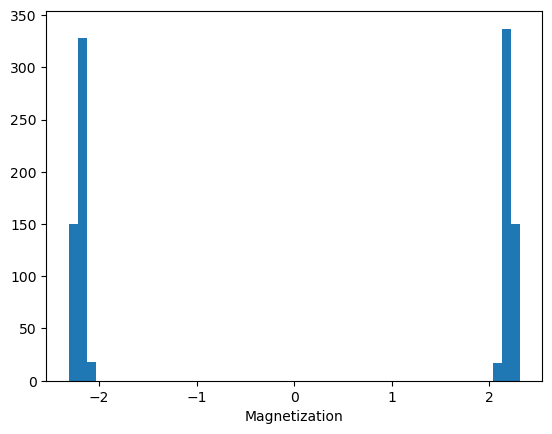

In [22]:
plt.hist(magnetization(training_samples).numpy(), bins=50)
plt.xlabel('Magnetization')
plt.show()

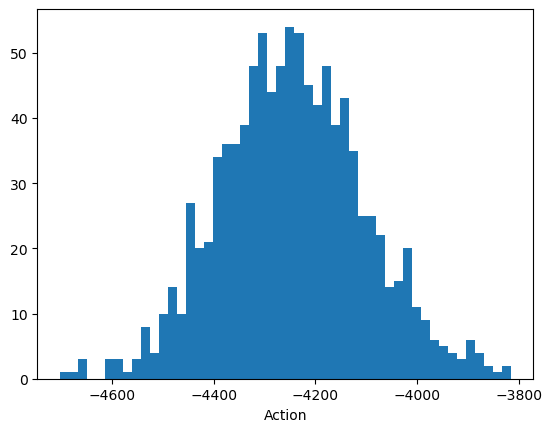

In [23]:
plt.hist(action(training_samples, kappa=0.5).numpy(), bins=50)
plt.xlabel('Action')
plt.show()

In [24]:
mean, var = jackknife(training_samples, magnetization_mean)
print('Magnetization of training samples: ', mean, ' +- ', var)

Magnetization of training samples:  tensor(0.0180)  +-  tensor(0.0963)


In [25]:
mean, var = jackknife(training_samples, susceptibility)
print('Susceptibility of training samples: ', mean, ' +- ', var)

Susceptibility of training samples:  tensor(1.5068)  +-  tensor(0.1017)


In [26]:
mean, var = jackknife(training_samples, binder_cumulant)
print('Binder cumulant of training samples: ', mean, ' +- ', var)

Binder cumulant of training samples:  tensor(0.6663)  +-  tensor(2.6039e-05)


In [27]:
# Random shuffle
index = torch.randperm(training_samples.shape[0])
training_samples = training_samples[index]

10.000 samples:

In [ ]:
torch.save(training_samples, r'training_samples_scalar_broken.pt')
           

1000 samples:

In [ ]:
torch.save(training_samples, r'test_samples_scalar_broken.pt')


### Symmetric phase

In [29]:
training_samples = hmc_alg(n=10000, hmc_steps=10000, kappa=0.22, tau=1e1, epsilon=3e-2).cpu()

  0%|          | 0/10000 [00:00<?, ?it/s]

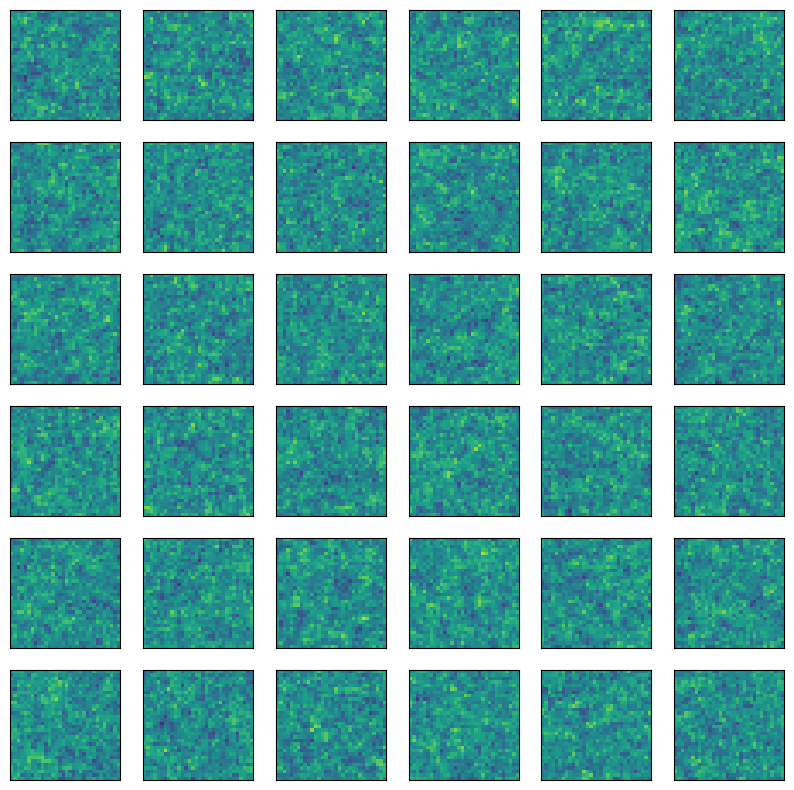

In [30]:
index = torch.randperm(training_samples.shape[0])
plot_samples(training_samples[index], img_per_row=6)

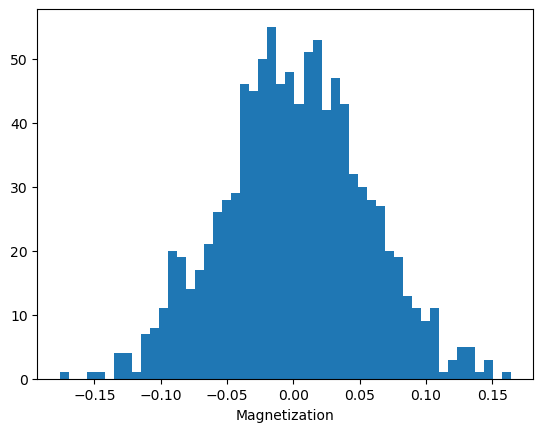

In [31]:
plt.hist(magnetization(training_samples).numpy(), bins=50)
plt.xlabel('Magnetization')
plt.show()

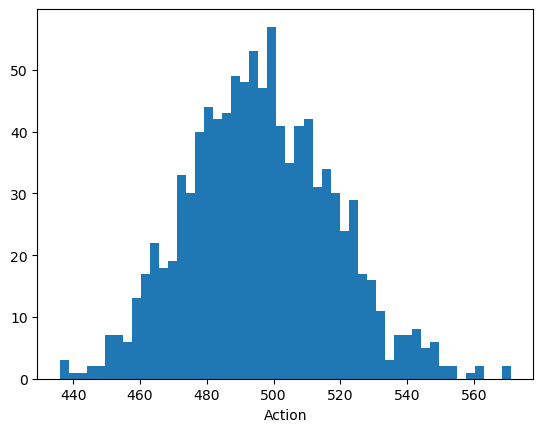

In [32]:
plt.hist(action(training_samples, kappa=0.21).numpy(), bins=50)
plt.xlabel('Action')
plt.show()

In [33]:
print('Magnetization of training samples: ', 
      jackknife(training_samples, magnetization_mean)[0], 
     ' +- ', jackknife(training_samples, magnetization_mean)[1])

Magnetization of training samples:  tensor(0.0009)  +-  tensor(0.0024)


In [34]:
print('Susceptibility of training samples: ', 
      jackknife(training_samples, susceptibility)[0], 
     ' +- ', jackknife(training_samples, susceptibility)[1])

Susceptibility of training samples:  tensor(1.0685)  +-  tensor(0.0774)


In [35]:
print('Binder cumulant of training samples: ', 
      jackknife(training_samples, binder_cumulant)[0], 
     ' +- ', jackknife(training_samples, binder_cumulant)[1])

Binder cumulant of training samples:  tensor(0.0315)  +-  tensor(0.0571)


In [36]:
# Random shuffle
index = torch.randperm(training_samples.shape[0])
training_samples = training_samples[index]

10.000 samples:

In [ ]:
torch.save(training_samples, r'training_samples_scalar_symmetric.pt')


1000 samples:

In [ ]:
torch.save(training_samples, r'test_samples_scalar_symmetric.pt')


### For the Carosso notebook

In [ ]:
grid_size = 20

In [ ]:
training_samples = hmc_alg(n=10000, hmc_steps=10000, kappa=0.22, tau=1e1, epsilon=3e-2).cpu()

In [ ]:
# Random shuffle
index = torch.randperm(training_samples.shape[0])
training_samples = training_samples[index]

In [ ]:
torch.save(training_samples, r'training_samples_scalar_20grid.pt')